In [134]:
import cv2
import pytesseract
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pytesseract

* 함수

In [135]:
# 이미지 출력 함수
def imshow(img, size=(15, 15)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.show()

# 이미지 전체 테두리 지우기, 경계선 검출시 필요
def draw_edge(img, margin=1):
    img[0:margin, :], img[-margin:, :], img[:, 0:margin], img[:, -margin:] = 255, 255, 255, 255
    return img

* 데이터불러오기

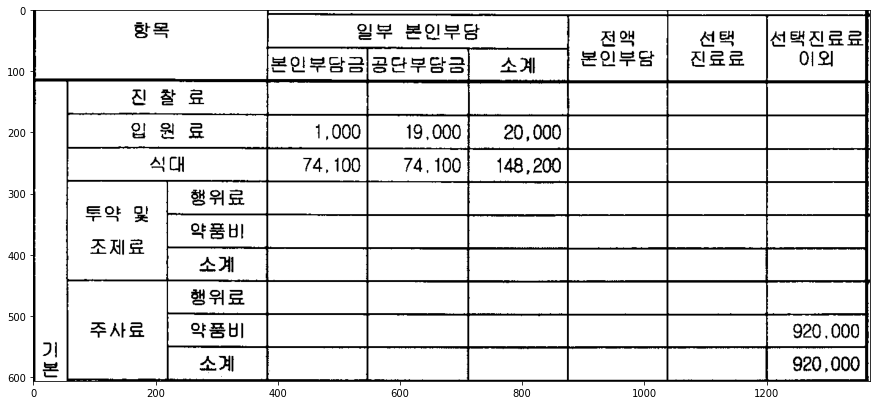

In [136]:
# PARAMETERS
path = '../img/'            # 원본이미지 경로
proc_path = '../proc_img/'  # 이진화 후 이미지 경로
cell_path = '../cell_img/'  # 셀구역을 표현한 이미지
split_path = '../sp_img/'   # 셀단위로 쪼개진 이미지
filename = 'image02.png' # 파일명

img = cv2.imread(path+filename, cv2.IMREAD_GRAYSCALE)  # 이미지 불러오기

# 이진화
bi_thr = 190
ret, bi_img = cv2.threshold(img, bi_thr, 255, cv2.THRESH_BINARY)
ret, bi_img_empty = cv2.threshold(img, 255, 255, cv2.THRESH_BINARY)     ## 빈 이미지 생성

imshow(bi_img)

* 직선검출 및 라인 제거

In [137]:
# 라인 추출을 위한 뭉개기
erotion = cv2.erode(bi_img, np.ones((3, 3), np.uint8), iterations=1)
kernel = np.ones((1, 31), np.uint8)
dilation_row = cv2.dilate(erotion, kernel, iterations=1)
kernel = np.ones((31, 1), np.uint8)
dilation_col = cv2.dilate(erotion, kernel, iterations=1)
dilation_row = cv2.bitwise_not(dilation_row)
dilation_col = cv2.bitwise_not(dilation_col)
# 라인 추출 수행 (사각형 기준 버전)
mod_img_row = copy.deepcopy(bi_img_empty)  # 이미지 복사
mod_img_col = copy.deepcopy(bi_img_empty)  # 이미지 복사
contours_row, hierarchy = cv2.findContours(dilation_row, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours_col, hierarchy = cv2.findContours(dilation_col, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours_row:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 30:
        cv2.rectangle(mod_img_row, (x - 15, y), (x + w + 14, y + h -1 ), (255, 255, 255), -1)
for cnt in contours_col:
    x, y, w, h = cv2.boundingRect(cnt)
    if h > 30:
        cv2.rectangle(mod_img_col, (x, y - 15), (x + w - 1, y + h + 14), (255, 255, 255), -1)       
line_img = cv2.add(mod_img_row, mod_img_col)   # 라인 이미지
rm_line_img = cv2.add(bi_img, line_img)        # 라인 제거 이미지

In [223]:
# 잡영 제거 (filter2D 활용)
kernel = np.ones((31,31),np.float32)/(31 * 31)
dst = cv2.filter2D(rm_line_img,-1, kernel)
ret, s2 = cv2.threshold(dst, 255 / 31 * 30 + 1, 255, cv2.THRESH_BINARY)

s2 = cv2.bitwise_not(s2)
rm_line_img_bk = cv2.bitwise_not(rm_line_img)
rm_line_img_re = cv2.add(rm_line_img, s2)
rm_line_img_re = cv2.bitwise_not(rm_line_img_re)
rm_line_img_cl = cv2.add(rm_line_img, rm_line_img_re)

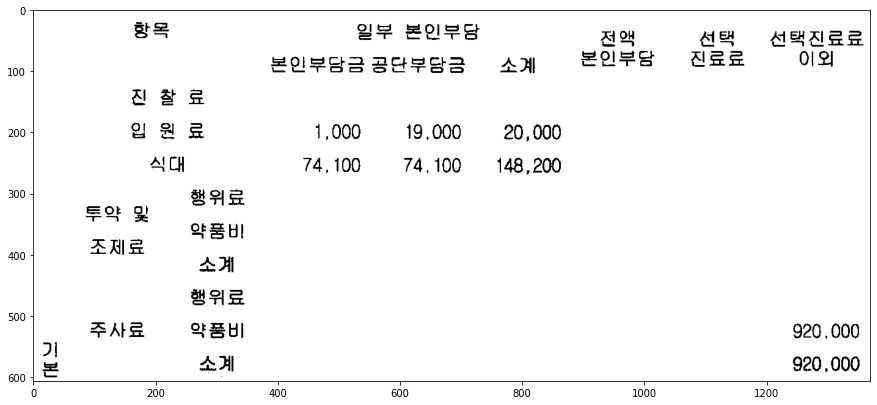

In [224]:
imshow(rm_line_img_cl)

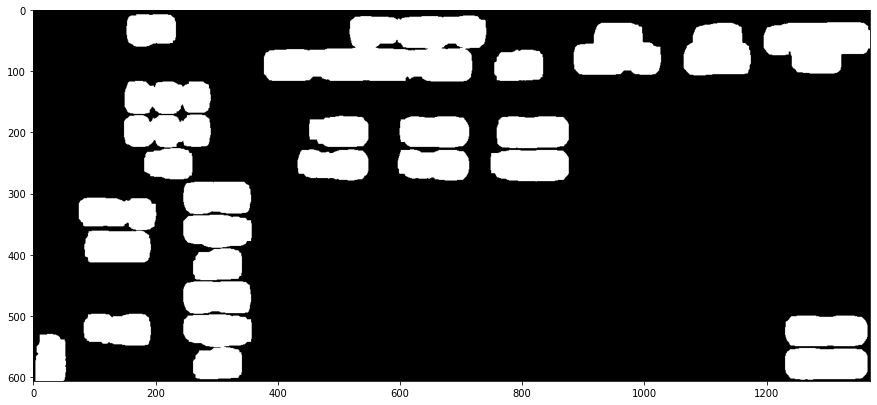

In [211]:
imshow(s2)

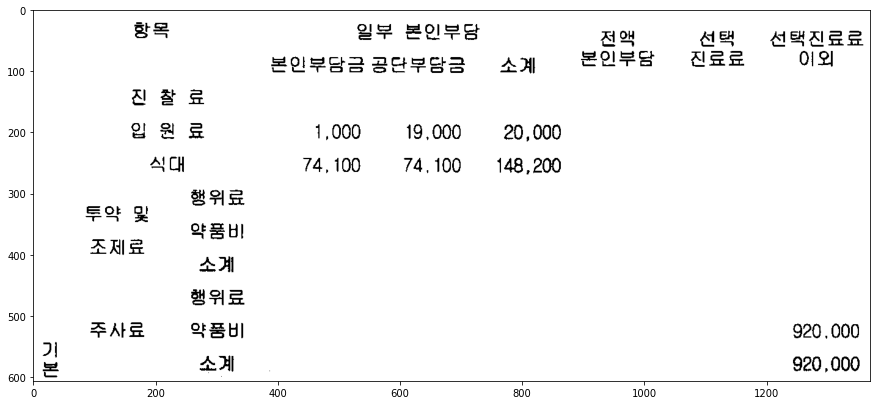

In [205]:
imshow(rm_line_img)

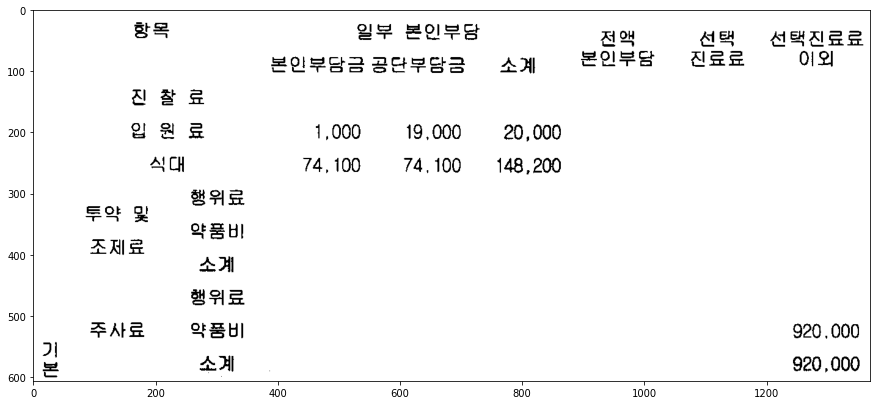

In [179]:
imshow(rm_line_img)

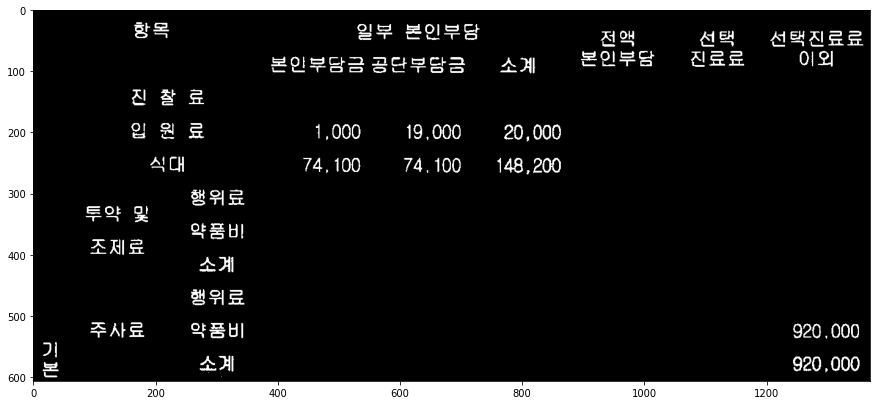

In [168]:
imshow(cv2.bitwise_not(rm_line_img_cl))

* 텍스트 영역 검출

In [132]:
erod_text = np.ones((2, 3) , np.uint8)
dilate_text = np.ones((2, 3) , np.uint8)

er_text_img = cv2.erode(rm_line_img_cl, erod_text, iterations=5)
er_text_img = cv2.dilate(er_text_img, dilate_text, iterations=1)
# er_text_img = cv2.erode(er_text_img, erod_text, iterations=2)
# er_text_img = cv2.dilate(er_text_img, dilate_text, iterations=2)

er_text_img = draw_edge(er_text_img, margin=1)  # 이미지 가장자리 흰색으로 칠함
#imshow(er_text_img)

In [82]:
# 작은 이미지를 박스쳐 버린다.
mod_img_box = copy.deepcopy(er_text_img)  # 이미지 복사
img_color = cv2.cvtColor(er_text_img,cv2.COLOR_GRAY2RGB)
contours, hierarchy = cv2.findContours(er_text_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if ((h < 15) & (w < 20)):
        cv2.rectangle(mod_img_box, (x, y), (x + w, y + h), (0, 0, 0), -1)

In [83]:
# get text box
back_img = cv2.cvtColor(bi_img, cv2.COLOR_GRAY2RGB)  # 배경이미지
#back_img = copy.deepcopy(bi_img_empty)
cnt_text, hier = cv2.findContours(er_text_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
text_area_list = list()
for cnt in cnt_text:
    x, y, w, h = cv2.boundingRect(cnt)
    # 전체 박스 제외
    if (20 < h < back_img.shape[0]-10):
        cv2.rectangle(back_img, (x, y), (x +w-1, y+h-1), (255, 0,  0), 2)
        text_area_list.append((x, y, x+w-1, y+h-1))
        
back_img = cv2.cvtColor(back_img, cv2.COLOR_BGR2RGB)

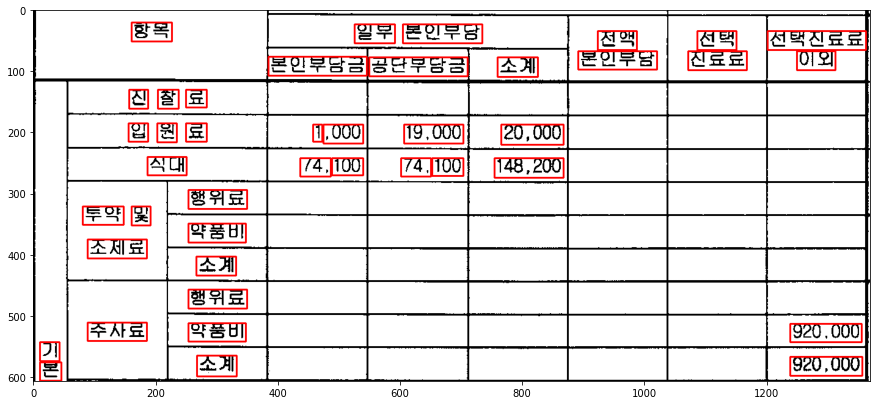

In [84]:
imshow(back_img)

* 라인, 셀 생성

In [85]:
# 라인생성
line_x, line_y = list(), list()  # 라인 좌표
cnt_row, hierarchy = cv2.findContours(dilation_row, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnt_col, hierarchy = cv2.findContours(dilation_col, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

min_hei = dilation_row.shape[0] / len(cnt_row)

for cnt in cnt_row:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 30:
        line_y.append(y)
for cnt in cnt_col:
    x, y, w, h = cv2.boundingRect(cnt)
    if h > 30:
        line_x.append(x)

line_x = sorted(line_x)
line_y = sorted(line_y)

#cnt_line = dilation_row.shape[0] / (len(line_y) + 10)
cnt_line = 20  # 텍스트 기본 사이즈 넣어야 할 듯
bef_ln = 0

a = range(len(line_y) - 1)
line_y2 = copy.deepcopy(line_y)

for ln in line_y2:
    if ln - bef_ln > cnt_line:
        bef_ln = ln
    else:
        line_y.remove(ln)


# 셀 생성
cell_dict = dict()
cell_list = list()

for n_x, x in enumerate(line_x):
    if n_x == len(line_x) - 1:
        pass
    else:
        for n_y, y in enumerate(line_y):
            if n_y == len(line_y) - 1:
                pass
            else:
                coord = (x, y, line_x[n_x+1], line_y[n_y+1])
                cell_list.append(coord)
                cell_dict[coord] = (n_x, n_y)
# cell 확인
back_img = cv2.cvtColor(rm_line_img,cv2.COLOR_GRAY2RGB)

for cell_coord in cell_list:
    cv2.rectangle(back_img, (cell_coord[0], cell_coord[1]), (cell_coord[2], cell_coord[3]), (255, 0, 0), 2)
#imshow(back_img)

* 텍스트 추출(오래걸림)

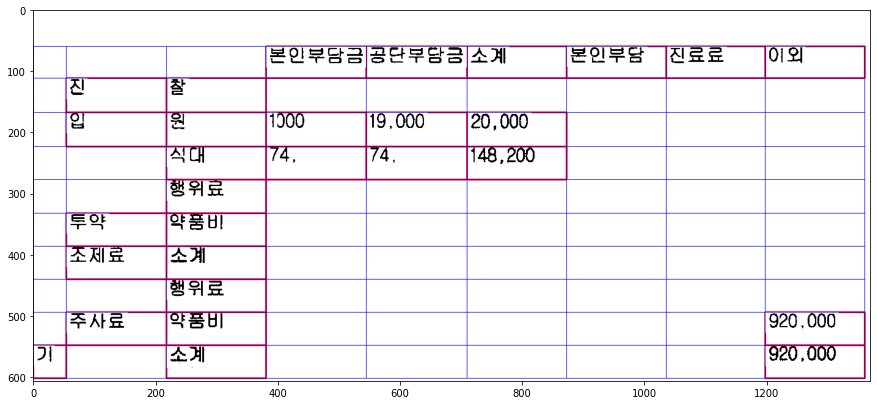

In [86]:
# 배경이미지
back_img = copy.deepcopy(rm_line_img)
back_img[:, :] = 255  # 흰색
back_img = cv2.cvtColor(back_img, cv2.COLOR_GRAY2RGB)
custom_oem_psm_config = r'--oem 1 --psm 8'
text_cell_list = list()
for text_coord in text_area_list:
    t_x1, t_y1, t_x2, t_y2 = text_coord       # 텍스트 좌표 추출
    text_mid = ((t_x1+t_x2)/2, (t_y1+t_y2)/2) # 텍스트 중간 좌표 추출
    mar = 2                                   # 텍스트 마진
    if (t_x2 + mar > rm_line_img.shape[1]) | (t_y2 + mar > rm_line_img.shape[0]) | (t_x1 - mar < 0) | (t_y1 - mar < 0):
        # 마진을 포함한 텍스트 영역이 이미지 전체 크기를 벗어날 때
        text_img = cv2.cvtColor(rm_line_img[t_y1:t_y2, t_x1:t_x2], cv2.COLOR_GRAY2RGB)
        text = pytesseract.image_to_string(text_img, lang = 'kor', config=custom_oem_psm_config)
    else:
        text_img = cv2.cvtColor(rm_line_img[t_y1 - mar :t_y2 + mar, t_x1 - mar :t_x2 + mar], cv2.COLOR_GRAY2RGB)
        text = pytesseract.image_to_string(text_img, lang = 'kor', config=custom_oem_psm_config)
    w, h =  text_img.shape[1], text_img.shape[0]  # 텍스트 영역 크기
    for cell_coord in cell_list:
        c_x1, c_y1, c_x2, c_y2 = cell_coord  # 셀좌표(좌상단, 우하단)
        if (c_x1 < text_mid[0] <c_x2) & (c_y1 < text_mid[1] < c_y2):
            # 텍스트 중간지점이 셀 영역 안에 있을 때
            cv2.rectangle(back_img, (c_x1, c_y1), (c_x2, c_y2), (0, 0, 255), 2)  # 셀 영역 붉은색으로 테두리
            area = back_img[c_y1: c_y1+h, c_x1: c_x1+w]  # 텍스트 영역
            if area.shape[0] < text_img.shape[0]:
                # 셀 영역이 텍스트 영역보다 작을 때
                diff = text_img.shape[0] - area.shape[0]
                back_img[c_y1: c_y1+h, c_x1: c_x1+w] = text_img[:-diff, :]
            elif area.shape[1] < text_img.shape[1]:
                diff = text_img.shape[1] - area.shape[1]
                back_img[c_y1: c_y1+h, c_x1: c_x1+w] = text_img[:, :-diff]
            else:
                # 배경 이미지 내 셀 좌표를 텍스트로 표시
                back_img[c_y1: c_y1+h, c_x1: c_x1+w] = text_img
            cell = cell_dict[cell_coord]                   # 셀 테이블 좌표 (행, 열)
            text_cell_list.append((text, cell, text_mid))  # 텍스트, 테이블 좌표, 텍스트 중심 좌표 추출
            sp_filename = filename.split('.')[0] + '_(' + str(cell[1]) + ',' + str(cell[0]) + ')_' + str(text_coord)  + '_.' + filename.split('.')[1]
            cv2.imwrite(split_path+sp_filename, text_img)  # 파일 저장
        else:
            # 텍스트 영역이 아니면 파란색으로 테두리 칠함
            cv2.rectangle(back_img, (c_x1, c_y1), (c_x2, c_y2), (255, 0, 0), 1)
            
cv2.imwrite(cell_path +filename, back_img)
imshow(back_img)


In [87]:
table = np.chararray(shape=(len(line_y)-1, len(line_x)-1), itemsize=30, unicode=True)  # 테이블 초기화
text_cell_list_sorted = sorted(text_cell_list, key=lambda tup: tup[2][0])  # 텍스트 중심좌표의 x 좌표 기준으로 정렬
for text_tup in text_cell_list_sorted:
    text, pos, mid_coord = text_tup
    table[pos[1], pos[0]] += text
table_df = pd.DataFrame(table)
display(table_df)

,0,1,2,3,4,5,6,7,8
0,,,,본인부담금,공단부담금,소계,본인부담,진료료,이외
1,,진,찰료,,,,,,
2,,일,원료,"1,000",19.000,"20,000",,,
3,,,식대,"74,100","74,100","148,200",,,
4,,,행위료,,,,,,
5,,투약및,약품비,,,,,,
6,,조제료,소계,,,,,,
7,,,행위료,,,,,,
8,,주사료,약품비,,,,,,920.000
9,기콘,,소계,,,,,,"39320,.000"


* 인식결과 표형태로 배열

In [191]:
samp = img[: 9,  :9]
samp[:, :] = 90
samp

array([[90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90]], dtype=uint8)

In [192]:
ker = np.ones((3, 3), np.float32) / (3*3)
ker

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]], dtype=float32)

In [194]:
fil = cv2.filter2D(samp, -1, ker)
fil

array([[90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90],
       [90, 90, 90, 90, 90, 90, 90, 90, 90]], dtype=uint8)

In [199]:
cv2.threshold(fil, 90, 255, cv2.THRESH_BINARY)

(90.0,
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8))

In [ ]:
255 * 